In [98]:
import tensorflow as tf

from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import *
from keras import backend

import matplotlib.pyplot as plt

# Train CNN on MNIST Dataset

In [54]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

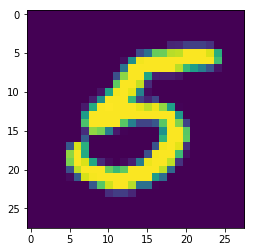

In [55]:
plt.imshow(X_train[757, ..., 0])
plt.show()

In [134]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation=tf.nn.relu, input_shape=(28, 28, 1), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'))
model.add(BatchNormalization())
 
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.20))
 
model.add(Conv2D(64, (3, 3), activation=tf.nn.relu, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation=tf.nn.relu, padding='same'))
model.add(BatchNormalization())
 
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.30))
 
model.add(Conv2D(128, (3, 3), activation=tf.nn.relu, padding='same'))
model.add(BatchNormalization())
 
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))
 
model.add(Flatten())
model.add(Dense(200, activation=tf.nn.relu))
model.add(BatchNormalization())
model.add(Dropout(0.50))
 
model.add(Dense(10, activation=tf.nn.softmax, name="output"))
 
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_26 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_27 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 14, 14, 64)        18496     
__________

In [135]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 273s 5ms/step - loss: 0.2387 - acc: 0.9279 - val_loss: 0.0453 - val_acc: 0.9837


# Create Class Activation Map

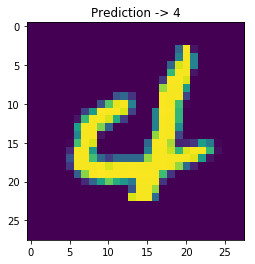

In [157]:
INDEX = 9947
instance = X_test[INDEX][None, ...]

prediction = np.argmax(model.predict(instance))

plt.title(f"Prediction -> {prediction}")
plt.imshow(instance[0, ..., 0])
plt.show()

In [191]:
TARGET = 4  # Which number to analyze
TARGET_INDICES = np.argwhere(y_test[:, TARGET]).ravel()

# Get Last Convolution Layer
convolution_layer = [layer for layer in model.layers if isinstance(layer, Conv2D)][-4]
convolution_layer_shape = int(convolution_layer.output.shape[1])

# Create Empty Heatmap
heatmap = np.zeros((convolution_layer_shape, convolution_layer_shape), np.float32)

# Iterate through instances of TARGET number
for j, INDEX in enumerate(TARGET_INDICES):
    print(f"\r[{j}/{len(TARGET_INDICES)}]", end="")
    
    # Get Instance
    instance = X_test[INDEX][None, ...]
    prediction = np.argmax(model.predict(instance))
    
    # Get Prediction Output
    output = model.output[:, prediction]

    # Get Pooled Gradients
    gradients = backend.mean(backend.gradients(output, convolution_layer.output)[0], axis=(0, 1, 2))

    # Combine Weights into one Heatmap
    iterate = backend.function([model.input], [gradients, convolution_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([instance])

    for i in range(convolution_layer_shape):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap += np.mean(conv_layer_output_value, axis=-1)

[161/982]

KeyboardInterrupt: 

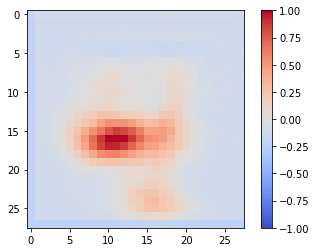

In [199]:
# Normalize Heatmap
heatmap -= heatmap.mean()
heatmap /= np.max(np.abs(heatmap))

# Plot Heatmap
plt.imshow(heatmap, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()